# Importing libraries

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from power.ml_ops.cross_val import get_folds, train_test_split, get_X_y_seq
from power.ml_ops.model import init_baseline_keras, compile_model, initialize_model, train_model

# tensforflow
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import Lambda

from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_rows', 500)

2024-04-09 11:56:34.113659: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-09 11:56:35.625363: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-09 11:56:35.629588: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 11:56:41.409744: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Process raw data

In [ ]:
raw_data = pd.read_csv('../raw_data/history_forecast_bulk_20171007_20240312.csv')

In [ ]:
def compress(df, **kwargs):
    """
    Reduces size of dataframe by downcasting numerical columns
    """
    input_size = df.memory_usage(index=True).sum()/ 1024
    print("new dataframe size: ", round(input_size,2), 'kB')

    in_size = df.memory_usage(index=True).sum()
    for type in ["float", "integer"]:
        l_cols = list(df.select_dtypes(include=type))
        for col in l_cols:
            df[col] = pd.to_numeric(df[col], downcast=type)
    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100

    print("optimized size by {} %".format(round(ratio,2)))
    print("new dataframe size: ", round(out_size / 1024,2), " kB")

    return df

In [ ]:
raw_data = compress(raw_data)

In [ ]:
df = raw_data.copy()

In [ ]:
df = df[['forecast dt iso', 'slice dt iso', 'temperature', 'dew_point', 'pressure',
       'ground_pressure', 'humidity', 'clouds', 'wind_speed', 'wind_deg',
       'rain', 'snow', 'ice', 'fr_rain', 'convective', 'snow_depth',
       'accumulated', 'hours', 'rate', 'probability']]

In [ ]:
df['forecast dt iso'] = df['forecast dt iso'].str.replace('+0000 UTC', '')
df['slice dt iso'] = df['slice dt iso'].str.replace('+0000 UTC', '')


In [ ]:
df.head()

In [ ]:
df = df[df['forecast dt iso'].str.contains('12:00:00')]
df

In [ ]:
df['forecast dt iso'] = pd.to_datetime(df['forecast dt iso'])
df['slice dt iso'] = pd.to_datetime(df['slice dt iso'])

In [ ]:
df.head()

In [ ]:
df_unique_dates = df['forecast dt iso'].unique()

In [ ]:
df[(df['forecast dt iso'] == df_unique_dates[0]) & (df['slice dt iso'].between(df_unique_dates[0] + timedelta(days=1) - timedelta(hours=12), df_unique_dates[0] + timedelta(days=1) + timedelta(hours=11)))]

In [ ]:
df_revised = []
for date in df_unique_dates:
    data = df[(df['forecast dt iso'] == date) & (df['slice dt iso'].between(date + timedelta(days=1) - timedelta(hours=12), date + timedelta(days=2) + timedelta(hours=11)))]
    df_revised.append(data)

In [ ]:
df_revised_ordered = pd.concat(df_revised, ignore_index=True)

In [ ]:
df_revised_ordered

In [ ]:
pv_weather_df = df_revised_ordered[df_revised_ordered['slice dt iso'] <= '2022-12-31 23:00:00']

In [ ]:
pv_weather_df

# Save processed data

In [ ]:
pv_weather_df.to_csv('../raw_data/weather_forecast_processed.csv')

# Load processed data

In [3]:
pv_weather_df =pd.read_csv('../raw_data/weather_forecast_processed.csv')
pv_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91704 entries, 0 to 91703
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       91704 non-null  int64  
 1   forecast dt iso  91704 non-null  object 
 2   slice dt iso     91704 non-null  object 
 3   temperature      91704 non-null  float64
 4   dew_point        91704 non-null  float64
 5   pressure         91704 non-null  float64
 6   ground_pressure  91704 non-null  float64
 7   humidity         91704 non-null  float64
 8   clouds           91704 non-null  float64
 9   wind_speed       91704 non-null  float64
 10  wind_deg         91704 non-null  float64
 11  rain             91704 non-null  float64
 12  snow             91704 non-null  float64
 13  ice              91704 non-null  float64
 14  fr_rain          91704 non-null  float64
 15  convective       91704 non-null  float64
 16  snow_depth       91704 non-null  float64
 17  accumulated 

In [4]:
data = pv_weather_df.copy()
data.rename(columns={'forecast dt iso':'utc_time', 'slice dt iso':'prediction_utc_time'}, inplace=True)
data['utc_time'] = pd.to_datetime(data['utc_time'])
data['prediction_utc_time'] = pd.to_datetime(data['prediction_utc_time'])
data

,Unnamed: 0,utc_time,prediction_utc_time,temperature,dew_point,pressure,ground_pressure,humidity,clouds,wind_speed,wind_deg,rain,snow,ice,fr_rain,convective,snow_depth,accumulated,hours,rate,probability
0,0,2017-10-07 12:00:00,2017-10-08 00:00:00,11.32,8.95,1004.54,999.00,85.20,100.0,7.20,256.97,0.33,0.0,0.0,0.0,0.000,0.0,0.33,1.0,0.000092,1.00
1,1,2017-10-07 12:00:00,2017-10-08 01:00:00,11.61,9.33,1004.57,998.99,85.79,100.0,6.63,264.93,0.24,0.0,0.0,0.0,0.000,0.0,0.24,1.0,0.000067,0.93
2,2,2017-10-07 12:00:00,2017-10-08 02:00:00,11.88,9.72,1004.76,999.14,86.47,100.0,5.95,272.80,0.19,0.0,0.0,0.0,0.000,0.0,0.19,1.0,0.000053,0.83
3,3,2017-10-07 12:00:00,2017-10-08 03:00:00,11.96,9.95,1005.14,999.47,87.40,99.0,5.53,278.61,0.15,0.0,0.0,0.0,0.042,0.0,0.15,1.0,0.000042,0.73
4,4,2017-10-07 12:00:00,2017-10-08 04:00:00,11.73,9.91,1005.75,1000.03,88.48,98.0,5.63,281.29,0.11,0.0,0.0,0.0,0.042,0.0,0.11,1.0,0.000031,0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91699,91699,2022-12-30 12:00:00,2022-12-31 19:00:00,14.22,9.86,1011.67,1005.96,74.97,100.0,7.52,224.03,0.00,0.0,0.0,0.0,0.062,0.0,0.00,1.0,0.000000,0.01
91700,91700,2022-12-30 12:00:00,2022-12-31 20:00:00,14.13,9.57,1011.77,1006.06,73.92,100.0,7.54,220.16,0.00,0.0,0.0,0.0,0.062,0.0,0.00,1.0,0.000000,0.01
91701,91701,2022-12-30 12:00:00,2022-12-31 21:00:00,14.09,9.18,1011.91,1006.21,72.20,100.0,7.56,217.79,0.00,0.0,0.0,0.0,0.062,0.0,0.00,1.0,0.000000,0.00
91702,91702,2022-12-30 12:00:00,2022-12-31 22:00:00,14.07,8.75,1012.14,1006.44,70.22,98.0,7.54,218.41,0.00,0.0,0.0,0.0,0.062,0.0,0.00,1.0,0.000000,0.00


In [5]:
input_date ='2020-12-06'
input_datetime = datetime.strptime(input_date, '%Y-%m-%d')
data[data.utc_time.dt.date == (input_datetime.date())].iloc[:,:10]

,Unnamed: 0,utc_time,prediction_utc_time,temperature,dew_point,pressure,ground_pressure,humidity,clouds,wind_speed
55488,55488,2020-12-06 12:00:00,2020-12-07 00:00:00,8.21,4.53,999.96,994.36,77.60,44.0,4.50
55489,55489,2020-12-06 12:00:00,2020-12-07 01:00:00,7.97,4.25,999.41,993.87,77.17,35.0,4.46
55490,55490,2020-12-06 12:00:00,2020-12-07 02:00:00,7.77,3.96,998.86,993.42,76.55,25.0,4.81
55491,55491,2020-12-06 12:00:00,2020-12-07 03:00:00,7.80,3.76,998.51,993.12,75.30,21.0,5.49
55492,55492,2020-12-06 12:00:00,2020-12-07 04:00:00,8.18,3.69,998.50,993.05,73.15,27.0,6.43
55493,55493,2020-12-06 12:00:00,2020-12-07 05:00:00,8.75,3.70,998.74,993.15,70.50,40.0,7.41
55494,55494,2020-12-06 12:00:00,2020-12-07 06:00:00,9.30,3.68,999.07,993.31,67.90,56.0,8.17
55495,55495,2020-12-06 12:00:00,2020-12-07 07:00:00,9.63,3.59,999.35,993.45,65.89,71.0,8.51
55496,55496,2020-12-06 12:00:00,2020-12-07 08:00:00,9.76,3.52,999.64,993.65,64.96,84.0,8.38
55497,55497,2020-12-06 12:00:00,2020-12-07 09:00:00,9.74,3.64,1000.02,994.00,65.60,93.0,7.77


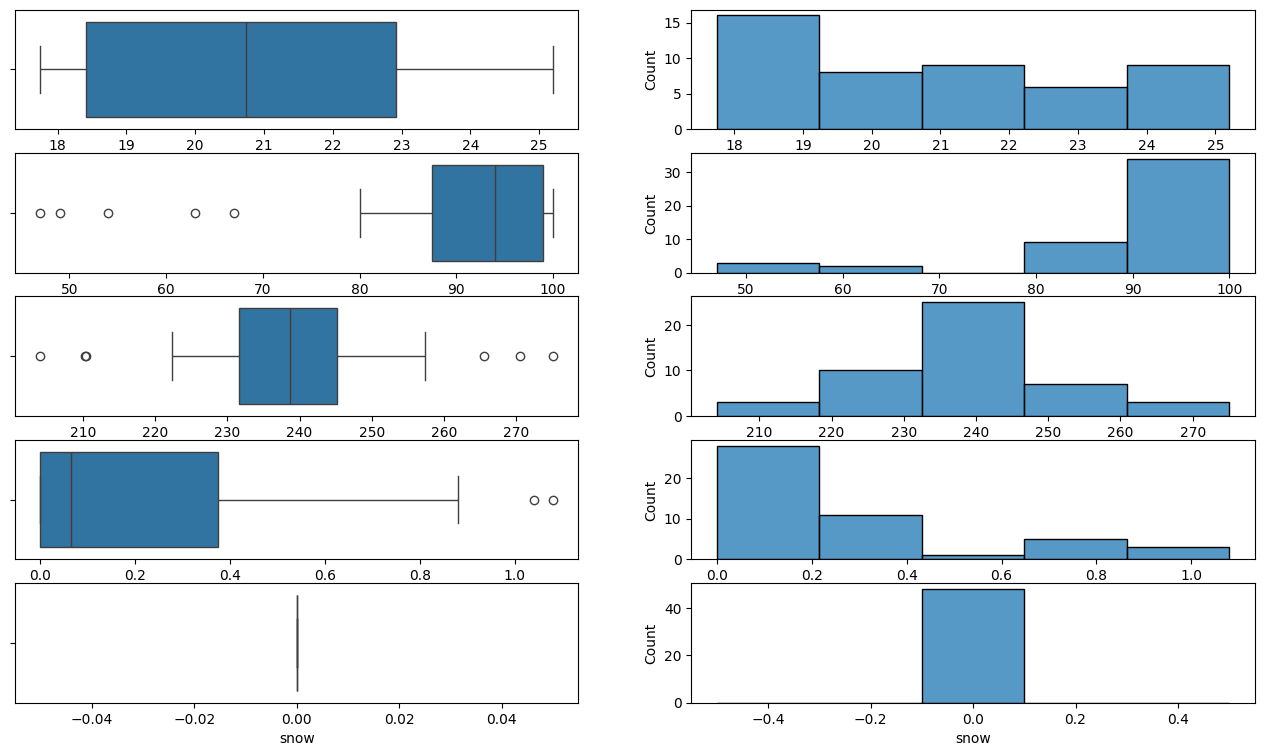

In [5]:
input_date ='2020-06-30'
input_datetime = datetime.strptime(input_date, '%Y-%m-%d')

df_forecast_day_before_input_date = data[data.utc_time.dt.date == (input_datetime.date() - timedelta(days=1))].iloc[-24:,:]
df_forecast_input_date = data[data.utc_time.dt.date == input_datetime.date()].iloc[:24,:]
df_forecast = pd.concat([df_forecast_day_before_input_date, df_forecast_input_date], axis=0).reset_index(drop=True)

features = ['temperature', 'clouds', 'wind_deg', 'rain', 'snow',]
X=df_forecast[features]
fig, ax = plt.subplots(nrows=5, ncols=2, figsize= (16,9))
for idx, feature in enumerate(features):
    sns.boxplot(data=X, x=feature, ax=ax[idx,0], legend='auto')
    sns.histplot(data=X, x=feature, ax=ax[idx,1], bins =5)
# df_forecast.iloc[:,0:10]

In [6]:
df_forecast.utc_time.nunique(), df_forecast.prediction_utc_time.nunique()


(2, 24)

In [7]:
df_forecast.utc_time.value_counts(), df_forecast.prediction_utc_time.value_counts()

(utc_time
 2020-06-29 12:00:00    24
 2020-06-30 12:00:00    24
 Name: count, dtype: int64,
 prediction_utc_time
 2020-07-01 00:00:00    2
 2020-07-01 01:00:00    2
 2020-07-01 22:00:00    2
 2020-07-01 21:00:00    2
 2020-07-01 20:00:00    2
 2020-07-01 19:00:00    2
 2020-07-01 18:00:00    2
 2020-07-01 17:00:00    2
 2020-07-01 16:00:00    2
 2020-07-01 15:00:00    2
 2020-07-01 14:00:00    2
 2020-07-01 13:00:00    2
 2020-07-01 12:00:00    2
 2020-07-01 11:00:00    2
 2020-07-01 10:00:00    2
 2020-07-01 09:00:00    2
 2020-07-01 08:00:00    2
 2020-07-01 07:00:00    2
 2020-07-01 06:00:00    2
 2020-07-01 05:00:00    2
 2020-07-01 04:00:00    2
 2020-07-01 03:00:00    2
 2020-07-01 02:00:00    2
 2020-07-01 23:00:00    2
 Name: count, dtype: int64)

In [8]:
scaler= MinMaxScaler()
X[features] = scaler.fit_transform(X[features])
X

/tmp/ipykernel_44328/1280110591.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[features] = scaler.fit_transform(X[features])


,temperature,clouds,wind_deg,rain,snow
0,0.049664,0.849057,0.515997,0.000000,0.0
1,0.036242,0.886792,0.488795,0.000000,0.0
2,0.013423,0.905660,0.451445,0.000000,0.0
3,0.000000,0.905660,0.437350,0.000000,0.0
4,0.012081,0.886792,0.466244,0.000000,0.0
5,0.045638,0.867925,0.507681,0.000000,0.0
6,0.096644,0.867925,0.517970,0.000000,0.0
7,0.162416,0.886792,0.467512,0.000000,0.0
8,0.255034,0.905660,0.382946,0.000000,0.0
9,0.391946,0.867925,0.304863,0.000000,0.0


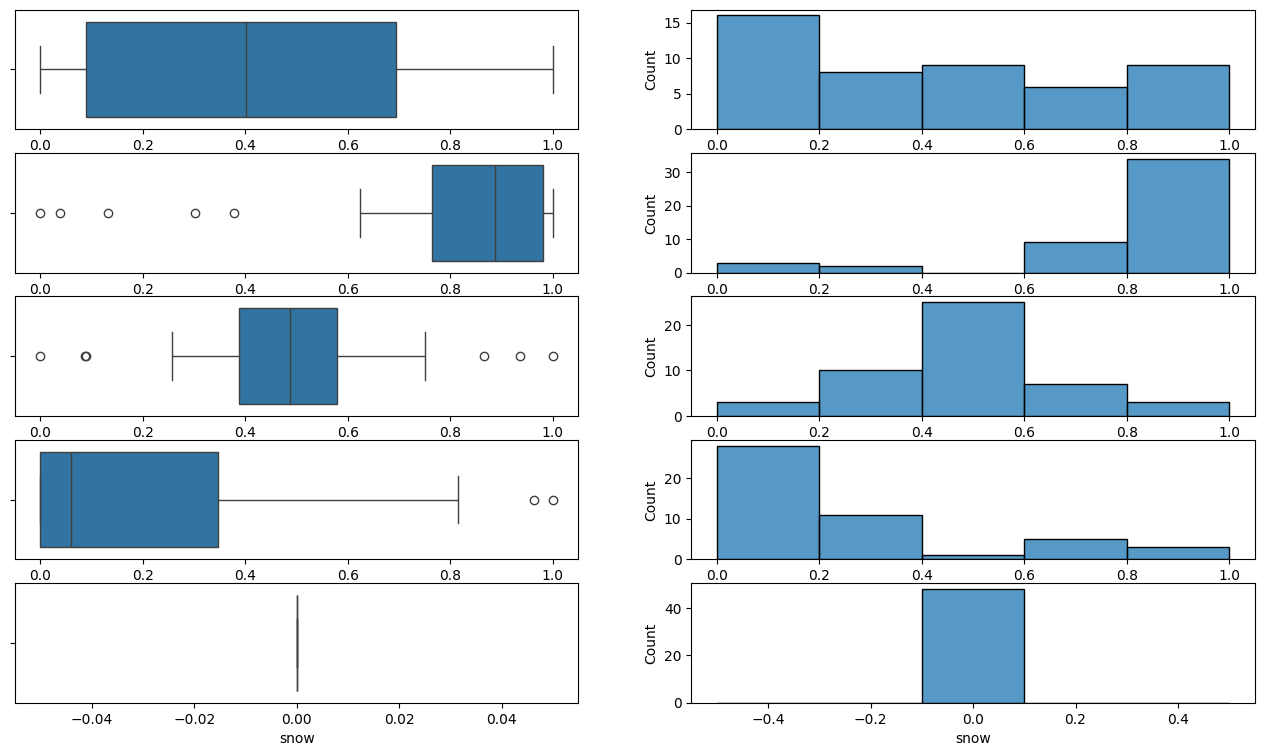

In [9]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize= (16,9))
for idx, feature in enumerate(features[-5:]):
    sns.boxplot(data=X, x=feature, ax=ax[idx,0], legend='auto')
    sns.histplot(data=X, x=feature, ax=ax[idx,1], bins =5)

# PSEUDO-CODE

when getting the 10_000 sequences, the dt index should be used to extract 48 observations and x features
rnow an ouput of shape (48,1)
should become an output (48, 1 + x)
call a data module.function to process the weather forecast features
concat the data somehow: np.concat? 


In [ ]:
############################################# For Jerome - ignore the rest ############################################################

In [7]:
pv_weather_df = pv_weather_df.rename(columns={'forecast dt iso': 'date_of_forcast',
                                              'slice dt iso': 'forcasting_date_range',
                                              'fr_rain': 'freezing_rain_vol',
                                            })

In [ ]:
pv_df

In [ ]:
comb_df = pd.merge(pv_weather_df, pv_df, )

In [ ]:
pv_df = df.copy()

In [ ]:
min_date = '1980-01-01 00:00:00'
max_date = '2019-12-31 23:00:00'
train = pv_df[pv_df['utc_time'] <= max_date]
test = pv_df[pv_df['utc_time'] > max_date]

In [ ]:
train = train[['electricity']]
test = test[['electricity']]

# Cross validation

In [ ]:
TARGET = 'electricity'
fold_length = 43800             # 5 years
fold_stride = 43800             # 5 years
train_test_ratio = 0.8          # 5 yrs/6 yrs
input_length = 48               # number of obsevations per one sequence
output_length = 24              # Day-ahead predictions
n_seq_train = 500               # number_of_sequences_train
n_seq_val = 100                 # number_of_sequences_test
n_unit = 48                     # number of hidden units
learning_rate = 0.02
patience = 5
epochs = 50
batch_size = 32

In [ ]:
def cross_validate_baseline_and_lstm():

    list_of_mae_baseline_model = []
    list_of_mae_recurrent_model = []

    # 0 - Creating folds
    # =========================================
    folds = get_folds(train, fold_length, fold_stride)

    for fold_id, fold in enumerate(folds):

        # 1 - Train/Test split the current fold
        # =========================================
        (fold_train, fold_val) = train_test_split(fold, train_test_ratio, input_length)

        X_train, y_train = get_X_y_seq(fold_train, n_seq_train, input_length, output_length, gap_hours=12)
        X_val, y_val = get_X_y_seq(fold_val, n_seq_val, input_length, output_length, gap_hours=12)

        # 2 - Modelling
        # =========================================

        ##### Baseline Model
        baseline_model = init_baseline_keras()
        mae_baseline = baseline_model.evaluate(X_val, y_val, verbose=0)[1]
        list_of_mae_baseline_model.append(mae_baseline)
        print("-"*50)
        print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")

        ##### LSTM Model
        model = initialize_model(X_train, y_train, n_unit=n_unit)
        model = compile_model(model, learning_rate=learning_rate)
        model, history = train_model(model,
                                     X_train,
                                     y_train,
                                     validation_split = 0.2,
                                     batch_size = batch_size,
                                     epochs = epochs)

        # Create a figure and axes object with 1 row and 2 columns
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

        # Plot training & validation MAE values
        axes[0].plot(history.history['mae'])
        axes[0].plot(history.history['val_mae'])
        axes[0].set_title('Model MAE')
        axes[0].set_ylabel('MAE')
        axes[0].set_xlabel('Epoch')
        axes[0].legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation loss values
        axes[1].plot(history.history['loss'])
        axes[1].plot(history.history['val_loss'])
        axes[1].set_title('Model Loss')
        axes[1].set_ylabel('Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].legend(['Train', 'Validation'], loc='upper left')

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Show the plot
        plt.show()

        res = model.evaluate(X_val, y_val, verbose=0)    # evaluating LSTM (metric)
        mae_lstm = res[1]
        list_of_mae_recurrent_model.append(mae_lstm)
        print(f"MAE LSTM fold n°{fold_id} = {round(mae_lstm, 2)}")

        ##### Comparison LSTM vs Baseline for the current fold
        print(f"improvement over baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")

    return list_of_mae_baseline_model, list_of_mae_recurrent_model


In [ ]:
mae_baselines, mae_lstms = cross_validate_baseline_and_lstm()

In [ ]:
print(f"average percentage improvement over baseline = {round(np.mean(1 - (np.array(mae_lstms)/np.array(mae_baselines))),2)*100}%")

# Prediction

In [ ]:
X_train, y_train = get_X_y_seq(train, number_of_sequences=10000, input_length=48, output_length=24, gap_hours=12)

In [ ]:
model = initialize_model(X_train, y_train, n_unit=n_unit)
model = compile_model(model, learning_rate=learning_rate)
model, history = train_model(model,
                                X_train,
                                y_train,
                                validation_split = 0.1,
                                batch_size = batch_size,
                                epochs = epochs)

In [ ]:
from power.params import *
from power.ml_ops.data import get_data_with_cache
from pathlib import Path
import tensorflow as tf

input_pred = '2021-05-08 12:00:00'

query = f"""
    SELECT *
    FROM {GCP_PROJECT}.{BQ_DATASET}.processed_pv
    ORDER BY utc_time
"""

data_processed_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_pv.csv")
data_processed = get_data_with_cache(
    gcp_project=GCP_PROJECT,
    query=query,
    cache_path=data_processed_cache_path,
    data_has_header=True
)

X_pred = data_processed[data_processed['utc_time'] < input_pred][-48:]

In [ ]:
X_pred = X_pred[['electricity']]

In [ ]:
X_pred = X_pred.to_numpy()
X_pred_tf = tf.convert_to_tensor(X_pred)
X_pred_tf = tf.expand_dims(X_pred_tf, axis=0)

In [ ]:
y_pred = model.predict(X_pred_tf)

In [ ]:
y_pred[0]

In [ ]:
plt.plot(y_pred[0])